# Maehara's method for multiple flares

Let's take all the methods and imports from the previous notebook:

[[466, 1684.0164142402712],
 [2489, 1686.8274547633812],
 [2490, 1686.828843618733],
 [3268, 1687.9218730742352],
 [4948, 1690.2898744776055],
 [4950, 1690.292652193781],
 [5248, 1690.7065319521423],
 [6642, 1692.675934328636],
 [7908, 1694.4411763853916],
 [8591, 1695.391157937432],
 [8594, 1695.3953245242076],
 [9095, 1696.0911445519644],
 [9107, 1696.1078108980198],
 [9118, 1696.1230883816222],
 [10800, 1699.4341336551386],
 [11921, 1700.9910497986527],
 [11997, 1701.0966034980222],
 [17000, 1708.0895527333198],
 [18435, 1710.0825838652179]]

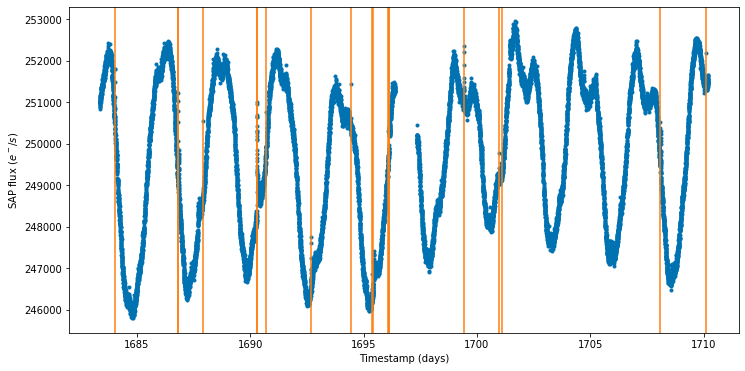

In [1]:
%matplotlib inline
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib as mp
import scipy
import pandas

mp.style.use('seaborn-colorblind')

def lcplot(t,f,color=""):
    '''
    Simple lightcurve plot function
    '''
    mp.rcParams['figure.figsize'] = [12, 6]
    plt.plot(t,f,color+".")
    plt.xlabel("Timestamp (days)")
    plt.ylabel(r"SAP flux ($e^-/s$)")

def lcminiplot(t,f,axs,i,j,color=""):
    axs[i,j].plot(t,f,color+".")

def slice_t_pdc(t,lc,t0,t1):
    '''
    Returns a tuple (tslice, lcslice) of the time and the lightcurve arrays
    between t0 and t1
    '''
    tslice1 = t[t < t1]
    tslice2 = tslice1[tslice1 > t0]
    lslice1 = lc[t < t1]
    lslice2 = lslice1[tslice1 > t0]
    return (tslice2,lslice2)
    
hdul = fits.open('tess2019198215352-s0014-0000000159613900-0150-s_lc.fits')
lcdata = hdul[1].data
pdcflux_raw = lcdata.field(7)
time_raw = lcdata.field(0)
has_errors = np.isnan(pdcflux_raw)
pdcflux = pdcflux_raw[~has_errors]
time = time_raw[~has_errors]

N = len(pdcflux)
jumps = np.zeros(N-1)
for i in range(1,N):
    jumps[i-1] = (pdcflux[i]-pdcflux[i-1])/(time[i]-time[i-1])

top02 = np.percentile(jumps[jumps > 0], 99.8, axis=None, out=None)
lcplot(time,pdcflux)

flare_candidates = []
for i in range(N-1):
    if jumps[i] > top02:
        flare_candidates.append([i,time[i]])
        plt.axvline(time[i],color='tab:orange')

flare_candidates

Now let's loop through all the flare candidates and give them a similar treatment: first take the slice of data around them (about 0.1 days/72 samples on each side), and put that in a dataframe of flare candidates.

POTENTIAL ISSUE: when the data goes into a break, this may go wrong

In [6]:
headers = ["Flare number","Time","Flux"]
df = pandas.DataFrame(columns=headers)

for i in range(len(flare_candidates)):
    # Do not include candidate if it is too close to the previous one
    if i > 0 and flare_candidates[i][1] < flare_candidates[i-1][1]+0.05:
        continue
    
    times = np.zeros(100)
    fluxes = np.zeros(100)
    
    for j in range(100):
        index = flare_candidates[i][0]+j-20
        times[j] = time[index]
        fluxes[j] = pdcflux[index]
    
    df.loc[i] = [i,times,fluxes]

df = df.reset_index(drop=True)

Then do a few miniplots of the data:

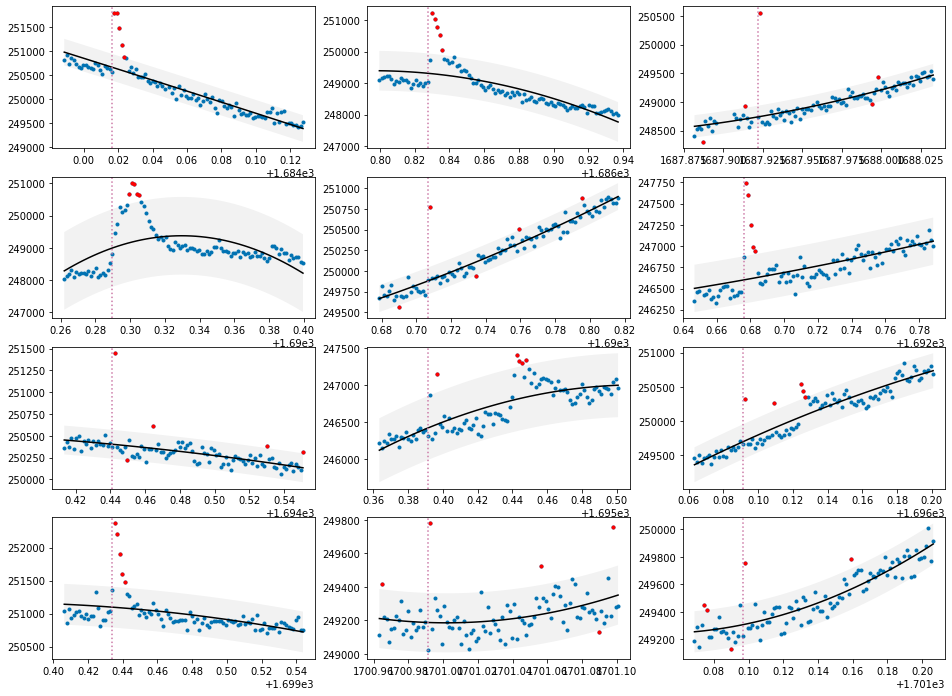

In [7]:
fig, axs = plt.subplots(4,3,figsize=(16,12))
for i in range(4):
    for j in range(3):
        data = df.loc[3*i+j]
        tslice = data[1]
        fslice = data[2]
        
        lcminiplot(tslice,fslice,axs,i,j)
        x = np.linspace(np.min(tslice),np.max(tslice))
        
        coeffs = np.polyfit(tslice,fslice,2)
        f = np.poly1d(coeffs)
        y = f(x)
        
        deviations = np.abs(fslice-f(tslice))
        maxdist = np.percentile(deviations, 95.0)
        outliers = fslice[deviations > maxdist]
        outliers_t = tslice[deviations > maxdist]
        
        lcminiplot(outliers_t,outliers,axs,i,j,color="r")
        
        #plt.legend(["All datapoints","Outliers"])
        axs[i,j].plot(x,y,"k")
        axs[i,j].axvline(tslice[20],color="C3",ls=":")
        axs[i,j].fill_between(x, y-maxdist, y+maxdist,
                facecolor='gray', alpha=0.1)

It appears that the method is recognizing quite a bit of non-flares (right, second from top; left, second from bottom; potentially center and right, second from bottom). We might want to at least exclude the flares with, say, fewer than 3 consecutive outlier points in the neighborhood of the flagged point.

In [8]:
row_iterator = df.iterrows()

for index, row in row_iterator:
    data=df.loc[index]
    
    tslice = data[1]
    fslice = data[2]
    
    coeffs = np.polyfit(tslice,fslice,2)
    f = np.poly1d(coeffs)
        
    deviations = np.abs(fslice-f(tslice))
    maxdist = np.percentile(deviations, 95.0)
    outliers = fslice[deviations > maxdist]
    
    flare = False
    
    for i in range(15,30):
        if all([(flux in outliers) for flux in fslice[i:i+3]]):
            flare = True
            break
    
    if not flare:
        df = df.drop(index)

df = df.reset_index(drop=True)

Alright, let's now plot the fits and the outliers from these.

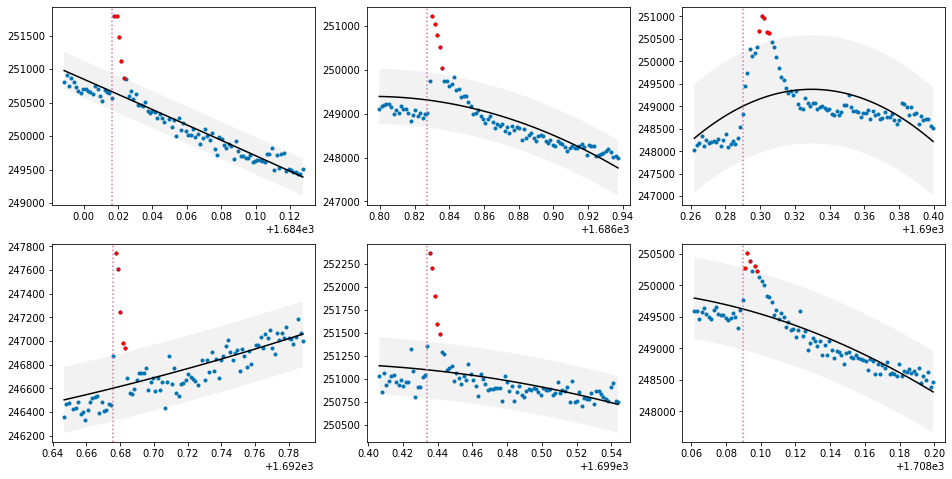

In [11]:
fig, axs = plt.subplots(2,3,figsize=(16,8))
for i in range(2):
    for j in range(3):
        data = df.loc[3*i+j]
        tslice = data[1]
        fslice = data[2]
        
        lcminiplot(tslice,fslice,axs,i,j)
        x = np.linspace(np.min(tslice),np.max(tslice))
        
        coeffs = np.polyfit(tslice,fslice,2)
        f = np.poly1d(coeffs)
        y = f(x)
        
        deviations = np.abs(fslice-f(tslice))
        maxdist = np.percentile(deviations, 95.0)
        outliers = fslice[deviations > maxdist]
        outliers_t = tslice[deviations > maxdist]
        
        lcminiplot(outliers_t,outliers,axs,i,j,color="r")
        
        #plt.legend(["All datapoints","Outliers"])
        axs[i,j].plot(x,y,"k")
        axs[i,j].axvline(tslice[20],color="C3",ls=":")
        axs[i,j].fill_between(x, y-maxdist, y+maxdist,
                facecolor='gray', alpha=0.1)

6 flare candidates remain, all separate. This seems to work.